In [2]:
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt

# Data import

In [3]:
with open("example-data.json", "r") as filehandle:
    data = json.load(filehandle)

# Data Parsing

In [4]:
data_parsed = [entry.replace(", ", ",") for entry in data]
data_parsed = [entry.split(",") for entry in data_parsed]
data_parsed = pd.DataFrame.from_dict(data_parsed)
data_parsed.columns = ["timestamp", "temp", "humid"]
# Convert temp and humid to numeric
data_parsed["temp"] = data_parsed["temp"].astype(float)
data_parsed["humid"] = data_parsed["humid"].astype(float)
# Last row is empty
data_parsed = data_parsed[:-1]
# Convert to datetime
data_parsed["timestamp"] = pd.to_datetime(data_parsed["timestamp"])


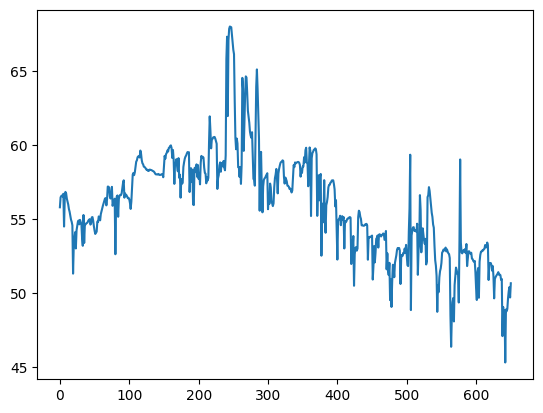

In [5]:
training_set = data_parsed.iloc[:,2:3].values

plt.plot(training_set, label = 'Humidity')
plt.show()

# Sliding Windows

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-2*seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+seq_length*2].reshape(-1, 1)
        x.append(_x)
        y.append(_y.reshape(1,-1)[0])

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 24
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.95)
test_size = len(y) - train_size
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Save minmax scaler

In [7]:
import joblib
joblib.dump(sc, 'humidity_preproc.joblib')

['humidity_preproc.joblib']

# ML

In [10]:
class LSTMModel(nn.Module):

    def __init__(self, seq_length=24):
        super(LSTMModel, self).__init__()
        
        self.num_classes = seq_length
        self.num_layers = 1
        self.input_size = 1
        self.hidden_size = 24
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))

        return out

In [11]:
num_epochs = 1500
learning_rate = 0.01

model = LSTMModel()

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Train the model
for epoch in range(num_epochs):
    model.train()
    outputs = model(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 500 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.00298
Epoch: 500, loss: 0.00337
Epoch: 1000, loss: 0.00226


#### Testing that it does different things with different input

##### Multistep Prediction

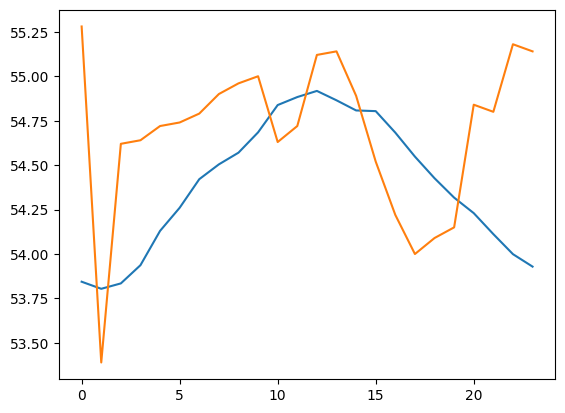

In [15]:
model.eval()
j = 10
base = dataX[j:j+1]
base = base.data.numpy().tolist()[0]

from collections import deque
cache = deque([], maxlen=24)
for value in base:
    cache.append(value)
cache = [cache]

predictions = []
prediction = model(torch.Tensor(cache))
for val in prediction[0]:
    prediction_transformed = sc.inverse_transform([[val.item()]])[0][0]
    predictions.append(prediction_transformed)

plt.plot(predictions)
dataY_plot = sc.inverse_transform(dataY[j].data.numpy().reshape(-1, 1))
plt.plot(dataY_plot)

##### Nice illustrative chart for train/test performance

In [ ]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [16]:
torch.save(model.state_dict(), "humidity_lstm.model") 

In [ ]:
new_model = LSTMModel()

In [ ]:
new_model.eval()
train_predict = new_model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
new_model.load_state_dict(torch.load("temperature_lstm.model"))

In [ ]:
new_model.eval()
train_predict = new_model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()